In [8]:
import json

import pandas as pd

from deep_ccf_registration.metadata import SubjectMetadata, AcquisitionDirection
import seaborn as sns

In [9]:
with open('/Users/adam.amster/smartspim-registration/subject_metadata.json') as f:
    subject_meta = json.load(f)
subject_meta = [SubjectMetadata(**x) for x in subject_meta]

# receptive field

In [6]:
def get_resolutions():
    resolutions = []
    for subject in subject_meta:
        right_to_left = [x for x in subject.axes if x.direction in (AcquisitionDirection.LEFT_TO_RIGHT, AcquisitionDirection.RIGHT_TO_LEFT)][0]
        superior_inferior = [x for x in subject.axes if x.direction in (AcquisitionDirection.SUPERIOR_TO_INFERIOR, AcquisitionDirection.INFERIOR_TO_SUPERIOR)][0]
        anterior_posterior = [x for x in subject.axes if x.direction in (AcquisitionDirection.POSTERIOR_TO_ANTERIOR, AcquisitionDirection.ANTERIOR_TO_POSTERIOR)][0]
        resolution = (right_to_left.resolution, superior_inferior.resolution, anterior_posterior.resolution)
        resolutions.append(resolution)
    return resolutions

resolutions = get_resolutions()

<Axes: xlabel='resolution', ylabel='count'>

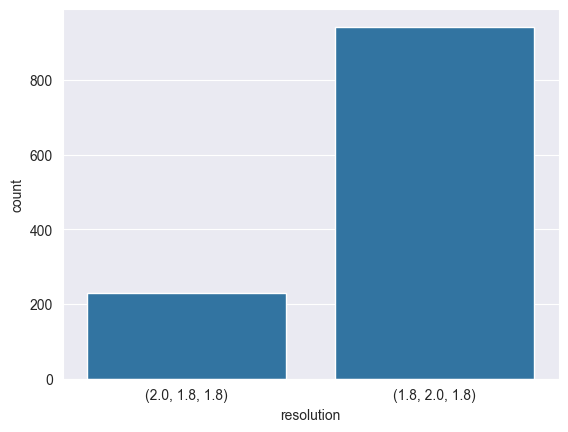

In [7]:
sns.countplot(pd.DataFrame({'resolution': resolutions}).astype(str), x='resolution')

with 5 layers, each with stride 2

final layer operates on input (1/2**5)^2 of original input

original input is 512x512 pixels, with physical size .0018 mm ^ 2

with 3x3 kernel, each cell corresponds to 32 input pixels, so receptive field is 96^2 pixels,
or 96 * .0018 mm = .17 mm^2

In [22]:
from scipy.interpolate import griddata
from matplotlib import pyplot as plt
import numpy as np
from deep_ccf_registration.metadata import AcquisitionAxis
from deep_ccf_registration.utils.tensorstore_utils import create_kvstore
import tensorstore
import ants


def _create_coordinate_dataframe(
        patch_height: int,
        patch_width: int,
        start_x: int,
        start_y: int,
        fixed_index_value: int,
        slice_axis: AcquisitionAxis,
        axes: list[AcquisitionAxis]
) -> pd.DataFrame:
    # Create meshgrid with actual coordinates
    axis1_coords, axis2_coords = np.meshgrid(
        np.arange(start_y, start_y + patch_height),
        np.arange(start_x, start_x + patch_width),
        indexing='ij'
    )

    axis1_flat = axis1_coords.flatten()
    axis2_flat = axis2_coords.flatten()

    n_points = len(axis1_flat)

    slice_index = np.full(n_points, fixed_index_value)

    axes = sorted(axes, key=lambda x: x.dimension)

    points = np.zeros((n_points, 3))

    points[:, slice_axis.dimension] = slice_index
    points[:, [x for x in axes if x != slice_axis][0].dimension] = axis1_flat
    points[:, [x for x in axes if x != slice_axis][1].dimension] = axis2_flat

    df = pd.DataFrame(data=points, columns=[x.name.value.lower() for x in axes]).astype(float)

    return df

def visualize_registration(subject_meta: list[SubjectMetadata]):
    volume = tensorstore.open(
                spec={
                    "driver": "auto",
                    "kvstore": create_kvstore(
                        path="/Users/adam.amster/smartspim-registration/806624.zarr/3",
                    ),
                },
                read=True,
            ).result()
    print(volume.shape)

    subject_meta = [x for x in subject_meta if x.subject_id == '806624'][0]
    input_indices = _create_coordinate_dataframe(
        patch_height=volume.shape[3],
        patch_width=volume.shape[4],
        start_x=0,
        start_y=0,
        fixed_index_value=int(volume.shape[2]/2),
        slice_axis=subject_meta.axes[0],
        axes=subject_meta.axes
    )

    # scale to full resolution
    input_indices *= 2**3

    with open('/Users/adam.amster/smartspim-registration/806624_acquisition.json') as f:
        acquisition = json.load(f)

    coord_transform = CoordinateTransform(
        name='smartspim_lca',
        dataset_transforms={
            'points_to_ccf': [
                "/Users/adam.amster/smartspim-registration/806624_ls_to_template_SyN_0GenericAffine.mat",
                "/Users/adam.amster/smartspim-registration/806624_ls_to_template_SyN_1InverseWarp.nii.gz",
            ]
        },
        acquisition=acquisition,
        image_metadata={'shape': tuple(np.array(volume.shape[2:]) * 2**3)},
        ls_template_path="/Users/adam.amster/.transform_utils/transform_utils/smartspim_lca/template/smartspim_lca_template_25.nii.gz"
    )

    template_points_affine_transformed, template_points_raw = coord_transform.forward_transform(input_indices, to_ccf=False, to_index_space=True, return_input_points_in_ls_template_space=True, affine_only=True)

    template_points_warp_transformed = coord_transform.forward_transform(input_indices, to_ccf=False, to_index_space=True, return_input_points_in_ls_template_space=False, affine_only=False)

    ls_template = ants.image_read("/Users/adam.amster/.transform_utils/transform_utils/smartspim_lca/template/smartspim_lca_template_25.nii.gz")

    input_image = volume[0, 0, int(volume.shape[2]/2)].read().result()
    intensities = input_image.flatten()

    ML_axis, DV_axis, SI_axis = 0, 1, 2

    # Template grid for SI-DV plane
    si_grid = np.arange(ls_template.shape[SI_axis])
    dv_grid = np.arange(ls_template.shape[DV_axis])
    SI, DV = np.meshgrid(si_grid, dv_grid)

    # Rasterize each set of points onto template grid
    def rasterize(pts, values=intensities):
        return griddata(pts[:, [SI_axis, DV_axis]], values, (SI, DV), method='linear')

    template_points_warp_transformed = np.array(template_points_warp_transformed)
    template_points_raw = np.array(template_points_raw)
    template_points_affine_transformed = np.array(template_points_affine_transformed)

    fixed = rasterize(template_points_warp_transformed)
    moving_raw = rasterize(template_points_raw)
    moving_affine = rasterize(template_points_affine_transformed)

    # Compute SI and DV displacement components
    displacement = template_points_warp_transformed - template_points_affine_transformed

    fig = plt.figure(figsize=(20, 10))

    # Row 1: SI-DV rasterized images
    ax1 = fig.add_subplot(2, 5, 1)
    ax1.imshow(moving_raw, origin='lower', cmap='gray')
    ax1.set_title('Moving')
    ax1.set_xlabel('SI')
    ax1.set_ylabel('DV')

    ax1 = fig.add_subplot(2, 5, 2)
    ax1.imshow(fixed, origin='lower', cmap='gray')
    ax1.set_title('Fixed (affine + warp)')
    ax1.set_xlabel('SI')
    ax1.set_ylabel('DV')

    ax2 = fig.add_subplot(2, 5, 3)
    ax2.imshow(fixed, origin='lower', cmap='gray', alpha=0.7)
    ax2.imshow(moving_raw, origin='lower', cmap='Reds', alpha=0.5)
    ax2.set_title('Raw vs Fixed')
    ax2.set_xlabel('SI')
    ax2.set_ylabel('DV')

    ax2 = fig.add_subplot(2, 5, 4)
    ax2.imshow(fixed, origin='lower', cmap='gray', alpha=0.7)
    ax2.imshow(moving_affine, origin='lower', cmap='Reds', alpha=0.5)
    ax2.set_title('Affine vs Fixed')
    ax2.set_xlabel('SI')
    ax2.set_ylabel('DV')

    ax3 = fig.add_subplot(2, 5, 5)
    step = 20
    si_disp_image = rasterize(template_points_affine_transformed, values=displacement[:, SI_axis])
    dv_disp_image = rasterize(template_points_affine_transformed, values=displacement[:, DV_axis])
    ax3.imshow(moving_affine, origin='lower', cmap='gray')
    ax3.quiver(
        np.arange(0, si_disp_image.shape[1], step),  # x positions (columns = SI)
        np.arange(0, si_disp_image.shape[0], step),  # y positions (rows = DV)
        si_disp_image[::step, ::step],  # u (SI direction)
        dv_disp_image[::step, ::step],  # v (DV direction)
        color='yellow',
        scale=300
    )
    ax3.set_title('SI-DV warp')
    ax3.set_xlabel('SI')
    ax3.set_ylabel('DV')

    # Row 2: 3D views
    step = 10
    idx = np.arange(0, len(intensities), step)

    # Use template shape for axis limits
    ml_lim = [0, ls_template.shape[ML_axis]]
    si_lim = [0, ls_template.shape[SI_axis]]
    dv_lim = [0, ls_template.shape[DV_axis]]

    # ML displacement for coloring
    ml_displacement = template_points_warp_transformed[:, ML_axis] - template_points_affine_transformed[:, ML_axis]
    ml_vmax = np.percentile(np.abs(ml_displacement), 95)

    for col, (pts, title, colors, cmap) in enumerate(zip(
        [template_points_raw, template_points_affine_transformed, template_points_warp_transformed],
        ['Raw', 'Affine only', 'ML warp displacement'],
        [intensities, intensities, ml_displacement],
        ['gray', 'gray', 'coolwarm'])):

        ax = fig.add_subplot(2, 4, col + 6, projection='3d')

        if cmap == 'coolwarm':
            sc = ax.scatter(pts[idx, ML_axis], pts[idx, SI_axis], pts[idx, DV_axis],
                       c=colors[idx], cmap=cmap, s=0.5, vmin=-ml_vmax, vmax=ml_vmax)
            plt.colorbar(sc, ax=ax, label='ML (voxels)', shrink=0.5)
        else:
            ax.scatter(pts[idx, ML_axis], pts[idx, SI_axis], pts[idx, DV_axis],
                       c=colors[idx], cmap=cmap, s=0.5)

        ax.view_init(elev=20, azim=45)
        ax.set_xlim(ml_lim)
        ax.set_ylim(si_lim)
        ax.set_zlim(dv_lim)
        ax.set_xlabel('ML')
        ax.set_ylabel('SI')
        ax.set_zlabel('DV')
        ax.set_title(title)
        ax.set_box_aspect([ls_template.shape[ML_axis], ls_template.shape[SI_axis], ls_template.shape[DV_axis]])

    return fig
fig = visualize_registration(subject_meta=subject_meta)
plt.show()
fig.savefig('/Users/adam.amster/Downloads/output.png')

AttributeError: module 'scipy.sparse' has no attribute 'linalg'

,ML,AP,SI
count,1172.000000,1172.000000,1172.000000
mean,884.827645,1217.572526,504.701365
std,100.359138,166.108637,70.931062
min,480.000000,920.000000,307.000000
25%,927.000000,1104.000000,471.750000
50%,928.000000,1280.000000,482.000000
75%,933.000000,1284.000000,525.250000
max,1168.000000,3270.000000,944.000000


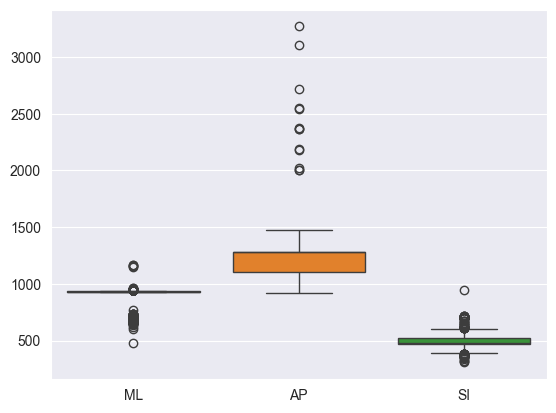

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

def volume_size_distr():
    with open('/Users/adam.amster/smartspim-registration/subject_metadata.json') as f:
        subject_meta = json.load(f)

    sizes = []
    for subject in subject_meta:
        subject = SubjectMetadata(**subject)
        ml_axis = [x for x in subject.axes if x.direction in (AcquisitionDirection.RIGHT_TO_LEFT, AcquisitionDirection.LEFT_TO_RIGHT)][0].dimension
        ap_axis = [x for x in subject.axes if x.direction in (AcquisitionDirection.ANTERIOR_TO_POSTERIOR, AcquisitionDirection.POSTERIOR_TO_ANTERIOR)][0].dimension
        si_axis = [x for x in subject.axes if x.direction in (AcquisitionDirection.SUPERIOR_TO_INFERIOR, AcquisitionDirection.INFERIOR_TO_SUPERIOR)][0].dimension

        sizes.append({'ML': subject.registered_shape[ml_axis], 'AP': subject.registered_shape[ap_axis], 'SI': subject.registered_shape[si_axis]})
    sizes = pd.DataFrame(sizes)
    sizes.to_csv('~/smartspim-registration/sizes.csv', index=False)
    display(sizes.describe())
    sns.boxplot(sizes)
    plt.show()
volume_size_distr()

## tissue bboxes

<Axes: ylabel='Count'>

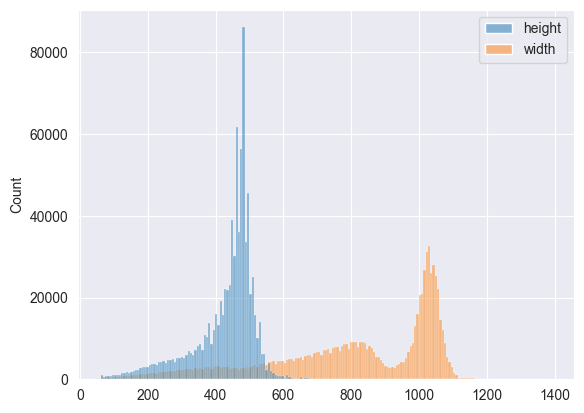

In [15]:
from deep_ccf_registration.metadata import SliceOrientation
import json



with open('/Users/adam.amster/smartspim-registration/tissue_bboxes.json') as f:
    bboxes = json.load(f)

bbox_dims = []
for subject in subject_meta:
    axes = sorted(subject.axes, key=lambda x: x.dimension)
    slice_axis = subject.get_slice_axis(orientation=SliceOrientation.SAGITTAL)
    subject_bboxes = bboxes[subject.subject_id]
    axes = [x for x in axes if x.dimension != slice_axis.dimension]
    for subject_bbox in [x for x in subject_bboxes if x is not None]:
        if axes[0].direction in (AcquisitionDirection.INFERIOR_TO_SUPERIOR, AcquisitionDirection.SUPERIOR_TO_INFERIOR):
            bbox_dims.append({'sid': subject.subject_id, 'height': subject_bbox['height'], 'width': subject_bbox['width']})
        elif axes[0].direction in (AcquisitionDirection.POSTERIOR_TO_ANTERIOR, AcquisitionDirection.ANTERIOR_TO_POSTERIOR):
            bbox_dims.append({'sid': subject.subject_id, 'height': subject_bbox['width'], 'width': subject_bbox['height']})
        else:
            raise ValueError

bbox_dims = pd.DataFrame(bbox_dims)
sns.histplot(bbox_dims)

In [44]:
with open('/Users/adam.amster/smartspim-registration/tissue_bboxes.json') as f:
    bboxes = json.load(f)

s_gaps = []
for sid, s_bboxes in bboxes.items():
    bbox_idxs = [i for i, x in enumerate(s_bboxes) if x is not None]
    min_bbox, max_bbox = bbox_idxs[0], bbox_idxs[-1]
    if list(range(min_bbox, max_bbox+1)) != bbox_idxs:
        gaps = [x for x in range(min_bbox, max_bbox+1) if x not in bbox_idxs]
        s_gaps.append((sid, gaps))
print(s_gaps)

[('770245', [670, 671, 672, 673, 674, 675, 676, 677, 678, 679])]


In [46]:
bboxes['770245'][660:690]

[{'y': 0, 'x': 293, 'width': 877, 'height': 460},
 {'y': 0, 'x': 295, 'width': 875, 'height': 460},
 {'y': 0, 'x': 295, 'width': 875, 'height': 460},
 {'y': 0, 'x': 297, 'width': 873, 'height': 460},
 {'y': 0, 'x': 297, 'width': 873, 'height': 460},
 {'y': 0, 'x': 298, 'width': 872, 'height': 460},
 {'y': 0, 'x': 300, 'width': 869, 'height': 460},
 {'y': 0, 'x': 300, 'width': 869, 'height': 460},
 {'y': 0, 'x': 302, 'width': 867, 'height': 460},
 {'y': 0, 'x': 303, 'width': 865, 'height': 460},
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 {'y': 3, 'x': 313, 'width': 852, 'height': 457},
 {'y': 3, 'x': 315, 'width': 849, 'height': 457},
 {'y': 3, 'x': 315, 'width': 849, 'height': 456},
 {'y': 4, 'x': 317, 'width': 847, 'height': 454},
 {'y': 4, 'x': 318, 'width': 845, 'height': 454},
 {'y': 4, 'x': 318, 'width': 845, 'height': 453},
 {'y': 5, 'x': 319, 'width': 844, 'height': 452},
 {'y': 4, 'x': 319, 'width': 844, 'height': 454},
 {'y': 5, 'x': 322, 'width': 8

In [31]:
bbox_dims.sort_values('width', ascending=False)

,sid,height,width
346022,785851,608,1391
346020,785851,608,1391
346018,785851,608,1391
346031,785851,608,1391
346030,785851,608,1391
...,...,...,...
343971,782296,61,61
348755,796013,61,61
358590,780619,62,61
359381,741335,61,61


In [32]:
1391*14.4/48

417.3

<Axes: ylabel='Count'>

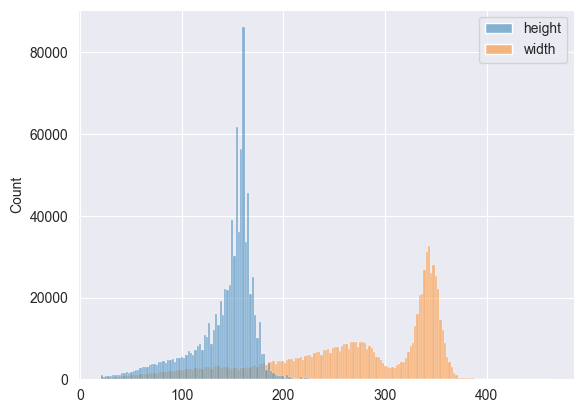

In [26]:
sns.histplot(bbox_dims.set_index('sid') * 16/48)

# rotation

In [29]:
rotation_angles = pd.read_csv('~/smartspim-registration/rotation_angles.csv')

rotation_angles.sort_values('pitch (around ML)', ascending=False)

,subject_id,roll (around AP),pitch (around ML),yaw (around DV)
944,747335,-5.174184,33.048142,6.066241
851,730476,-12.785367,32.124239,25.002885
283,731336,-19.199128,31.008064,-1.720369
726,751023,-14.392633,30.792134,33.941595
677,725231,-3.841512,30.333938,10.525938
...,...,...,...,...
152,731616,11.580547,-17.975423,-4.250118
157,717442,18.698322,-18.980468,-0.279371
476,AK032,-9.805337,-20.917400,2.520580
901,AK035,8.914818,-21.199916,4.228933
